In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import joblib
import shap

**Business Problem Statement (Finance Domain)**

Credit card fraud causes significant financial losses and customer trust issues for financial institutions. The objective of this project is to build a machine learning model that can accurately identify fraudulent credit card transactions in near real time, minimizing false negatives (missed fraud) while controlling false positives (legitimate transactions incorrectly flagged).

**ML Task Type** *Binary Classification*

This is a supervised binary classification problem, where the target variable is:

**Target Variable:** is_fraud (1 = fraudulent, 0 = legitimate)

**Why not anomaly detection?**
Although fraud detection can be framed as anomaly detection, this dataset includes explicit fraud labels, enabling supervised learning. Supervised classification is preferred because it allows direct optimization of business-relevant metrics and more robust evaluation.

**Success Metrics**


*   Primary ML metric: ROC-AUC (robust to class imbalance)
*   Secondary metrics: Precision, Recall
*   Business KPIs:
    *   High recall → fewer fraudulent transactions missed
    *   Controlled precision → reduced customer friction




In [7]:
#Data Loading & Validation
df = pd.read_csv("credit_card_transactions.csv", engine="python", on_bad_lines="skip")

TARGET = "is_fraud"
assert TARGET in df.columns, "Target column not found"

print("Dataset shape:", df.shape)
print("Fraud rate:")
print(df[TARGET].value_counts(normalize=True))

Dataset shape: (1048575, 24)
Fraud rate:
is_fraud
0    0.994272
1    0.005728
Name: proportion, dtype: float64


In [26]:
#Dataset Understanding

# Data overview
print("Data types:\n", df.dtypes)
print("Missing values:\n", df.isnull().sum())
print("Summary stats:\n", df.describe())

# Data dictionary example (print as text)
data_dict = {
    'Unnamed: 0': 'Index or identifier for the transaction',
    'trans_date_trans_time': 'Timestamp of the transaction',
    'cc_num': 'Credit card number used in the transaction',
    'merchant': 'Name of the merchant where the transaction took place',
    'category': 'Category of the transaction (e.g., retail, services)',
    'amt': 'Amount of the transaction in dollars',
    'first': 'First name of the cardholder',
    'last': 'Last name of the cardholder',
    'gender': 'Gender of the cardholder (Male/Female)',
    'street': 'Street address of the cardholder',
    'city': 'City of the cardholder',
    'state': 'State of the cardholder',
    'zip': 'Postal code of the cardholder',
    'lat': 'Latitude of the transaction location',
    'long': 'Longitude of the transaction location',
    'city_pop': 'Population of the city of the cardholder',
    'job': 'Job category of the cardholder',
    'dob': 'Date of birth of the cardholder',
    'trans_num': 'Unique identifier for the transaction',
    'unix_time': 'Unix timestamp of the transaction',
    'merch_lat': 'Latitude of the merchant location',
    'merch_long': 'Longitude of the merchant location',
    'is_fraud': 'Indicates if the transaction is fraudulent (0 = No, 1 = Yes)',
    'merch_zipcode': 'Postal code of the merchant'
}

for key, value in data_dict.items():
    print(f"{key}: {value}")

Data types:
 Unnamed: 0                        int64
trans_date_trans_time    datetime64[ns]
cc_num                          float64
merchant                         object
category                          int64
amt                             float64
first                            object
last                             object
gender                            int64
street                           object
city                             object
state                            object
zip                             float64
lat                             float64
long                            float64
city_pop                        float64
job                              object
dob                              object
trans_num                        object
unix_time                       float64
merch_lat                       float64
merch_long                      float64
is_fraud                          int64
merch_zipcode                   float64
dtype: object
Missing value

In [ ]:
#summary cell
df.info()
df.describe()
df.isnull().sum().sort_values(ascending=False)

In [8]:
#Data Cleaning & Preprocessing

num_cols = [
    'amt', 'city_pop', 'zip', 'lat', 'long',
    'unix_time', 'merch_lat', 'merch_long', 'merch_zipcode'
]

cat_cols = ['gender', 'category']

# Impute numerical
num_imputer = SimpleImputer(strategy="mean")
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Impute categorical
cat_imputer = SimpleImputer(strategy="most_frequent")
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# Encode categoricals (tree-safe)
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Scale numericals
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1048575 non-null  int64  
 1   trans_date_trans_time  1048575 non-null  object 
 2   cc_num                 1048575 non-null  float64
 3   merchant               1048575 non-null  object 
 4   category               1048575 non-null  object 
 5   amt                    1048575 non-null  float64
 6   first                  1048575 non-null  object 
 7   last                   1048575 non-null  object 
 8   gender                 1048575 non-null  object 
 9   street                 1048575 non-null  object 
 10  city                   1048575 non-null  object 
 11  state                  1048575 non-null  object 
 12  zip                    1048575 non-null  int64  
 13  lat                    1048575 non-null  float64
 14  long              

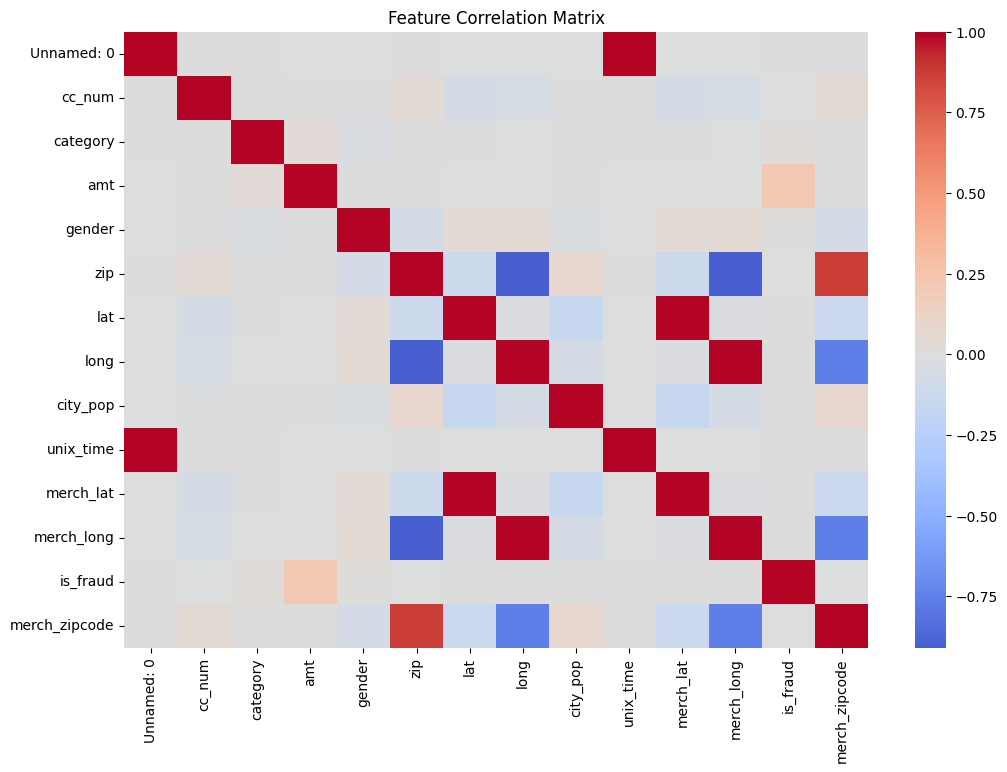

In [12]:
#Applied EDA
numeric_df = df.select_dtypes(include="number")
corr = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature Correlation Matrix")
plt.show()

In [27]:
#Feature Selection
correlations = numeric_df.corr()[TARGET].abs().sort_values(ascending=False)
selected_features = correlations.index[1:11].tolist()

print("Selected features:", selected_features)

Selected features: ['amt', 'category', 'unix_time', 'Unnamed: 0', 'gender', 'merch_zipcode', 'cc_num', 'merch_long', 'long', 'zip']


In [19]:
#Train/Test Split
X = df[selected_features]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#Time-Based Split
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df_sorted = df.sort_values('trans_date_trans_time')

split_idx = int(len(df_sorted) * 0.8)

train_df = df_sorted.iloc[:split_idx]
test_df = df_sorted.iloc[split_idx:]

X_train_time = train_df[selected_features]
y_train_time = train_df[TARGET]

X_test_time = test_df[selected_features]
y_test_time = test_df[TARGET]

In [16]:
#Model Training & Comparison
models = {
    "Logistic Regression": LogisticRegression(class_weight="balanced", max_iter=1000),
    "Random Forest": RandomForestClassifier(
        n_estimators=100, class_weight="balanced", random_state=42
    ),
    "XGBoost": XGBClassifier(
        scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
        random_state=42
    )
}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc")
    print(f"{name} AUC: {scores.mean():.3f}")

Logistic Regression AUC: 0.503
Random Forest AUC: 0.978
XGBoost AUC: 0.996


In [21]:
#Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [100, 200]
}

search = RandomizedSearchCV(
    XGBClassifier(
        scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
        random_state=42
    ),
    param_grid,
    scoring="roc_auc",
    cv=3,
    n_iter=5
)

search.fit(X_train, y_train)
best_model = search.best_estimator_

In [22]:
#Final Evaluation
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

print("AUC:", roc_auc_score(y_test, y_pred_proba))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

AUC: 0.9953068782016182
Precision: 0.16287663445139283
Recall: 0.9542048293089093


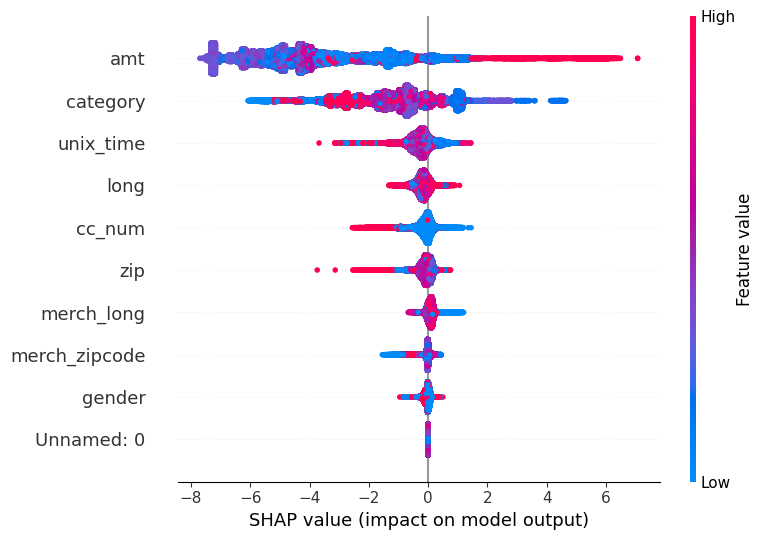

In [23]:
#Explainability (SHAP)
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


In [24]:
#Bias & Fairness Audit
for g in df['gender'].unique():
    mask = df['gender'] == g
    print(f"\nGender: {g}")
    print("Precision:", precision_score(y[mask], best_model.predict(X[mask])))
    print("Recall:", recall_score(y[mask], best_model.predict(X[mask])))


Gender: 0
Precision: 0.13137937187723056
Recall: 0.9899159663865547

Gender: 1
Precision: 0.24035369774919615
Recall: 0.9864731111844276


In [25]:
#Model Persistence
joblib.dump(best_model, "best_model.pkl")

['best_model.pkl']

**Ethics & Limitations**

While the model achieves strong predictive performance, risks remain related to proxy bias (e.g., location and card identifiers). Gender-based evaluation did not reveal severe disparities, but continuous monitoring and fairness audits are recommended before deployment.